In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision import models, transforms
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
f = open("data/dataset_info.txt", "r")
labels = f.readlines()[1:]
f.close()

name_label = {}
lb_list = []

for i in range(len(labels)):
    lb = labels[i].replace("\n", "").strip().split(". ")[1]
    lb_list.append(lb)
    name_label[lb] = 0
    
for i in range(len(lb_list)):
    name_label[lb_list[i]] += i
    
label_name = list(name_label.keys())


In [3]:
class LoadImageDataset(Dataset):
    def __init__(self, imgname_labels_file, img_dir, transform_data = None, typee = 'train',train = True):
        self.df_imgname_labels = pd.read_csv(imgname_labels_file)
        self.df_imgname_labels = shuffle(self.df_imgname_labels)
        if(typee == 'train'):
            self.df_imgname_labels = self.df_imgname_labels[:9000]
        if(typee == 'val'):
            self.df_imgname_labels = self.df_imgname_labels[9000:]
        
        
        self.img_dir = img_dir
        self.transform_data =  transform_data
        self.train = train
        
    def __len__(self):
        return len(self.df_imgname_labels)
    
    def __getitem__(self, idx):
        path = self.img_dir + self.df_imgname_labels.iloc[idx, 0]
        img =  read_image(path)/ 255.
        result = {"image": img, "label": -1}
        if self.train:
            lb = self.df_imgname_labels.iloc[idx, 1]
            result["label"] = lb
            if self.transform_data:
                result["label"] = self.transform_data['labels'](result["label"])
                result["image"] = self.transform_data['images'](result["image"])
        else:
            lb = 0
            result["label"] = lb
            if self.transform_data: 
                result["image"] = self.transform_data['images'](result["image"])
        
        return result

In [4]:
def train(path = "data/", batch_size = 8, epochs = 20):
    loss_arr = []
    val_loss_arr = []
     
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print("Using {} device".format(device))
    model = MyNetwork().to(device)
    print(model)
    
    transform_data =  {
        'images': 
                transforms.Compose([
                transforms.Resize((256, 256), interpolation = transforms.functional.InterpolationMode.BICUBIC),
                transforms.CenterCrop((224, 224)),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ]),
        'labels': 
                transforms.Compose([
                transforms.Lambda(lambda y: name_label[y])
                ])
    }
   
    train_dataloader = DataLoader(LoadImageDataset(path + "train.csv", path + "train_images/", transform_data, typee='train'), batch_size = batch_size,  num_workers=2, shuffle=True)
    val_dataloader = DataLoader(LoadImageDataset(path + "train.csv", path + "train_images/", transform_data, typee='val'), batch_size = batch_size,  num_workers=2, shuffle=True)
    loss_fun = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    for epoch in range(epochs):
        total_loss = 0
        val_loss = 0
        
        for  dic in train_dataloader:
            X = dic["image"].to(device)
            y = dic["label"].to(device)
            
            # forward pass
            y_preds = model(X)
            loss = loss_fun(y_preds, y)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        for  dic in val_dataloader:
            X = dic["image"].to(device)
            y = dic["label"].to(device)
            
            y_preds = model(X)
            loss = loss_fun(y_preds, y)
            val_loss += loss.item()
       
        total_loss /= len(train_dataloader.dataset)
        val_loss /= len(val_dataloader.dataset)
        loss_arr.append(total_loss)
        val_loss_arr.append(val_loss)
        
        print("Epoch: "+ str(epoch+1) + " | loss: "+str(total_loss) + " | val loss: "+str(val_loss), flush = True)
    
    return loss_arr, val_loss_arr


def plot(loss_arr, val_loss_arr):
    ind = np.arange(1, len(loss_arr)+1)
    plt.plot(ind, np.array(loss_arr))
    plt.plot(ind, np.array(val_loss_arr))
    plt.legend(['Train', 'Val'], loc='upper left')


## Playing with Activation functions

In [5]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 6),
            nn.MaxPool2d(kernel_size = (4,4)),
           
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 16),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            
            nn.Linear(in_features = 2304, out_features = 1024, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = 1024, out_features = len(name_label), bias = True),
            nn.Softmax()
        )
    def forward(self, x):
        return self.model(x)


Using cuda device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2304, out_features=1024, bias=True)
    (10): ReLU()
    (11): Linear(in_features=1024, out_features=62, bias=True)
    (12): Softmax(dim=None)
  )
)


/home/avani.gupta/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | loss: -0.010955467978230141 | val loss: -0.018961990281695207
Epoch: 2 | loss: -0.012783492916074 | val loss: -0.018587653854183206
Epoch: 3 | loss: -0.011064172118415296 | val loss: -0.015739187694829494
Epoch: 4 | loss: -0.010484051378702794 | val loss: -0.01780185758513932
Epoch: 5 | loss: -0.011505096812388264 | val loss: -0.013802580698650905
Epoch: 6 | loss: -0.012113482142521224 | val loss: -0.018833851343016943
Epoch: 7 | loss: -0.012811583106883353 | val loss: -0.015007434992982216
Epoch: 8 | loss: -0.012064813686647415 | val loss: -0.016124716129723722
Epoch: 9 | loss: -0.012323041256416416 | val loss: -0.015094004261942394
Epoch: 10 | loss: -0.012289675329367018 | val loss: -0.015487298295053244


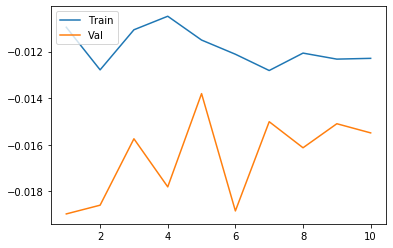

In [6]:
epochs = 10
loss_arr, val_loss_arr= train(epochs = epochs)
plot(loss_arr, val_loss_arr)

Using cuda device
MyNetwork(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2304, out_features=1024, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Linear(in_features=1024, out_features=62, bias=True)
    (12): Softmax(dim=None)
  )
)


/home/avani.gupta/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | loss: -0.007007931428557616 | val loss: -0.008904471974800396
Epoch: 2 | loss: -0.012997446633629875 | val loss: -0.012770966162776924
Epoch: 3 | loss: -0.014301666522376162 | val loss: -0.015737874589117865
Epoch: 4 | loss: -0.013645231094042212 | val loss: -0.012255222213040193
Epoch: 5 | loss: -0.014266562661426311 | val loss: -0.012701024471013398
Epoch: 6 | loss: -0.013598352185642289 | val loss: -0.01354486622575492
Epoch: 7 | loss: -0.014144149285114337 | val loss: -0.008126756724189416
Epoch: 8 | loss: -0.013181127881169508 | val loss: -0.0112226654551603
Epoch: 9 | loss: -0.011797605799723828 | val loss: -0.007223942533900892
Epoch: 10 | loss: -0.007871361226824676 | val loss: -0.011437778733586791


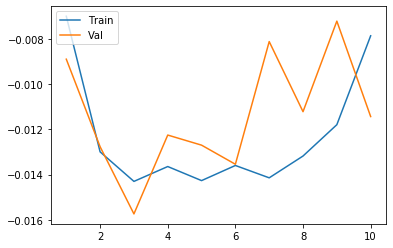

In [7]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.BatchNorm2d(num_features = 6),
            nn.MaxPool2d(kernel_size = (4,4)),
           
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.BatchNorm2d(num_features = 16),
            nn.MaxPool2d(kernel_size = (4,4)),
            nn.Flatten(),
            
            nn.Linear(in_features = 2304, out_features = 1024, bias=True),
            nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.Linear(in_features = 1024, out_features = len(name_label), bias = True),
            nn.Softmax()
        )
    def forward(self, x):
        return self.model(x)

epochs = 10
loss_arr, val_loss_arr= train(epochs = epochs)
plot(loss_arr, val_loss_arr)